# Elementos de redes neuronales

Sin preámbulo alguno, construiremos una red neuronal desde cero, explicando a detalle cada paso. En primer lugar, crearemos la «clase» `Numero`, es decir, formularemos una estructura que nos permita definir, modificar y operar con números. Dado que las redes neuronales son gigantescas expresiones matemáticas, los números serán nuestros átomos. De momento, cada número tendrá las siguientes propiedades: un valor, un par de valores previos que pueden generarlo (por ejemplo, 1 y 1 en el caso de que sumados nos den el número 2), la operación que genera al número y una etiqueta en caso de que queramos asociarlo a una variable. Por último, agregaremos la suma, la resta y la multiplicación para poder operar con nuestros números:

In [101]:
import math
class Numero:
  def __init__(self, valor, _previos=(), _op='', etiqueta=''):
    self.valor = valor
    self._previos = set(_previos)
    self._op = _op
    self.etiqueta = etiqueta
    eps = 1e-5

  def __repr__(self):
    return f'Valor={self.valor}' # esta función determina cómo se representa nuestro número

  def __add__(self, otro): # adición
    otro = otro if isinstance(otro, Numero) else Numero(otro) # nos cercioramos de que el otro valor sea un Número
    resultado = Numero(self.valor + otro.valor, (self, otro), '+')
    return resultado

  def __radd__(self, otro): # en Python, debemos apoyarnos de una función extra (con prefijo r) para casos en los que la función anterior no funcione
    return self + otro

  def __mul__(self, otro): # multiplicación
    otro = otro if isinstance(otro, Numero) else Numero(otro)
    resultado = Numero(self.valor * otro.valor, (self, otro), '*')
    return resultado

  def __rmul__(self, otro):
    return self * otro

  def __sub__(self, otro): # resta, substracción
    return self + (-otro)

  def __rsub__(self, otro):
    return otro + (-self)

  def __pow__(self, otro):
    assert isinstance(otro, (int, float))
    resultado = Numero(self.valor**otro, (self,), f'**{otro}')
    return resultado

  def __truediv__(self, otro): # división
    return otro * self**-1 #dividir es lo mismo que multiplicar por el dividendo elevado a la menos 1
  
  def __rtruediv__(self, otro):
    return otro * self**-1

  def __neg__(self): # volver negativo un número
    return self * -1


In [102]:
a = Numero(2, etiqueta='a') # definimos dos Números: a y b
b = Numero(5, etiqueta='b')
c = a*b # definimos c, que es el resultado de multiplicar a y b

print(f'{c} | Valores previos: {c._previos}, | Operación realizada para generar c: {c._op}')

Valor=10 | Valores previos: {Valor=2, Valor=5}, | Operación realizada para generar c: *


Antes de pasar a revisar conceptos más complicados, podemos visualizar de mejor manera lo que acabamos de hacer. A continuación, programaremos una función para graficar, pero explicarla queda fuera del enfoque de este texto.

In [103]:
from graphviz import Digraph

def rastreo(origen):
  # construye un conjunto de todos los nodos en un gráfico
  nodos, lineas = set(), set()
  def construir(v):
    if v not in nodos:
      nodos.add(v)
      for parte in v._previos:
        lineas.add((parte, v))
        construir(parte)
  construir(origen)
  return nodos, lineas

def graficar(origen):
  grafica = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # left to right, izquierda a derecha

  nodos, lineas = rastreo(origen)
  for n in nodos:
    uid = str(id(n))
    # por cada valor en la grafica, crea un nodo rectangular ('record') para él
    grafica.node(name=uid, label='{ %s | valor %.4f}' % (n.etiqueta, n.valor), shape='record')
    if n._op:
      # si el valor es resultado de una operación, crea un nodo para la operación
      grafica.node(name = uid + n._op, label = n._op)
      # conecta los nodos
      grafica.edge(uid + n._op, uid)

  for n1, n2 in lineas:
    # conecta n1 al nodo operación de n2
    grafica.edge(str(id(n1)), str(id(n2)) + n2._op)

  return grafica

{margin}
*Para saber más sobre funciones, véase nuestra [lección anterior](https://dantenoguez.github.io/Ensayos/elementos-program.html).*

Una vez definida la función, podemos graficar los resultados que vimos para la variable $c$:

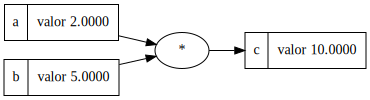

In [104]:
c.etiqueta = 'c'
graficar(c)

En este esquema queda más claro que la multiplicación es una función. Podemos ahora definir una función más compleja:

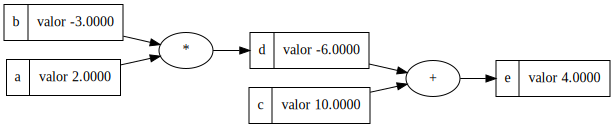

In [105]:
a = Numero(2.0, etiqueta='a')
b = Numero(-3.0, etiqueta='b')
c = Numero(10.0, etiqueta='c')
d = a*b; d.etiqueta='d'
e = d+c; e.etiqueta='e'

graficar(e)

Ahora, supongamos que, a través de los valores $a$ o $b$, queremos influir en el valor de $e$ para llevarlo a 0. ¿Cómo podríamos hacerlo? Con fuerza bruta, podríamos aumentar $a$ (ojo: si lo disminuyéramos, aumentaríamos el valor de $e$, puesto que $a$ está siendo multiplicada por un valor negativo: $b = -3$) por un valor pequeño y hacer pruebas hasta conseguir 0.

In [111]:
aumento = 0.001
a = Numero(2.0, etiqueta='a')
a += aumento
b = Numero(-3.0, etiqueta='b')
c = Numero(10.0, etiqueta='c')
d = a*b; d.etiqueta='d'
e = d+c; e.etiqueta='e'

e

Valor=3.997

Hemos conseguido disminuir el valor de $e$, pero nuestro método no parece eficiente. Si pudiéramos alterar $b$ y $a$ al mismo tiempo, en la dirección correcta y en la magnitud adecuada, nuestro método mejoraría. 